# Xopt Evaluator Basic Usage 

The `Evaluator` handles the execution of the user-provided `function` with optional `function_kwags`, asyncrhonously and parallel, with exception handling. 

In [1]:
# needed for macos
import platform
if platform.system() == "Darwin": import multiprocessing;multiprocessing.set_start_method("fork")


In [2]:
from xopt import Xopt, Evaluator, Generator, VOCS
from xopt.generators.random import RandomGenerator

from time import sleep
from numpy.random import randint

from typing import Dict

import numpy as np
np.random.seed(666) # for reproducibility

Define a custom function `f(inputs: Dict) -> outputs: Dict`. 

In [3]:
def f(inputs: Dict) -> Dict:

    sleep(randint(1, 5)*.1)  # simulate computation time
    # Make some occasional errors
    if np.any(inputs["x"] > 0.8):
        raise ValueError("x > 0.8")

    return {"f1": inputs["x"] ** 2 + inputs["y"] ** 2}

Define variables, objectives, constraints, and other settings (VOCS)

In [4]:
vocs = VOCS(variables={"x": [0, 1], "y": [0, 1]}, objectives={"f1": "MINIMIZE"})
vocs



VOCS(variables={'x': [0.0, 1.0], 'y': [0.0, 1.0]}, constraints={}, objectives={'f1': 'MINIMIZE'}, constants={}, linked_variables={})

This can be used to make some random inputs for evaluating the function. 

In [5]:
in1 = vocs.random_inputs()

f(in1)

{'f1': 0.11401572022703582}

In [6]:
# Add in occasional errors. 
try:
    f({"x": 1, "y": 0})
except Exception as ex:
    print(f"Caught error in f: {ex}")

Caught error in f: x > 0.8


In [7]:
# Create Evaluator
ev = Evaluator(function=f)

In [8]:
# Single input evaluation
ev.evaluate(in1)

{'xopt_exception': None,
 'xopt_traceback': '',
 'xopt_runtime': 0.20113283299999907,
 'f1': 0.11401572022703582,
 'xopt_error': False}

In [9]:
# Dataframe evaluation
in10 = vocs.random_inputs(10)
ev.evaluate_data(in10)


,xopt_exception,xopt_traceback,xopt_runtime,f1,xopt_error
0,None,,0.304741,0.529588,False
1,None,,0.403881,1.154098,False
2,None,,0.205012,0.641450,False
3,None,,0.200805,0.619825,False
4,None,,0.105087,0.536923,False
5,None,,0.300533,0.342636,False
6,None,,0.102354,0.589861,False
7,None,,0.403020,0.556977,False
8,None,,0.305124,0.055586,False
9,None,,0.305108,0.785844,False


In [10]:
# Dataframe evaluation, vectorized
ev.vectorized = True
ev.evaluate_data(in10)


,xopt_exception,xopt_traceback,xopt_runtime,f1,xopt_error
0,None,,0.301875,0.529588,False
1,None,,0.301875,1.154098,False
2,None,,0.301875,0.641450,False
3,None,,0.301875,0.619825,False
4,None,,0.301875,0.536923,False
5,None,,0.301875,0.342636,False
6,None,,0.301875,0.589861,False
7,None,,0.301875,0.556977,False
8,None,,0.301875,0.055586,False
9,None,,0.301875,0.785844,False


In [11]:
futures = ev.submit_data(in10)
for ix, fut in futures.items():
    print(fut.result())

{'xopt_exception': None, 'xopt_traceback': '', 'xopt_runtime': 0.30406587500000093, 'f1': 0.5295876188736232, 'xopt_error': False}
{'xopt_exception': None, 'xopt_traceback': '', 'xopt_runtime': 0.10506066700000005, 'f1': 1.154097903998413, 'xopt_error': False}
{'xopt_exception': None, 'xopt_traceback': '', 'xopt_runtime': 0.10202720900000095, 'f1': 0.641449645681512, 'xopt_error': False}
{'xopt_exception': None, 'xopt_traceback': '', 'xopt_runtime': 0.40520387499999977, 'f1': 0.6198251611679085, 'xopt_error': False}
{'xopt_exception': None, 'xopt_traceback': '', 'xopt_runtime': 0.30512595799999964, 'f1': 0.5369228584400957, 'xopt_error': False}
{'xopt_exception': None, 'xopt_traceback': '', 'xopt_runtime': 0.20275633299999996, 'f1': 0.3426360721182605, 'xopt_error': False}
{'xopt_exception': None, 'xopt_traceback': '', 'xopt_runtime': 0.404676499999999, 'f1': 0.5898614653804399, 'xopt_error': False}
{'xopt_exception': None, 'xopt_traceback': '', 'xopt_runtime': 0.30087341599999995, 'f1

# Evaluator in the Xopt object

In [12]:
X = Xopt(generator=RandomGenerator(vocs), evaluator=Evaluator(function=f), vocs=vocs)

# Submit to the evaluator some new inputs
X.submit_data(vocs.random_inputs(4))

# Unevaluated inputs are collected in a dataframe
X._input_data

,x,y
1,0.583288,0.224807
2,0.256953,0.780591
3,0.630404,0.920658
4,0.924833,0.513219


In [13]:
# Internal futures dictionary
X._futures

{1: <Future at 0x14f7e5970 state=finished returned dict>,
 2: <Future at 0x14f78fe50 state=finished returned dict>,
 3: <Future at 0x14f78ffa0 state=finished returned dict>,
 4: <Future at 0x14f78f700 state=finished returned dict>}

In [14]:
# Collect all finished futures and updata dataframe
X.process_futures()
X.data

,x,y,xopt_exception,xopt_traceback,xopt_runtime,f1,xopt_error,xopt_error_str
1,0.583288,0.224807,None,,0.401517,0.390763,False,NaN
2,0.256953,0.780591,None,,0.402529,0.675347,False,NaN
3,0.630404,0.920658,None,,0.402310,1.245020,False,NaN
4,0.924833,0.513219,x > 0.8,"Traceback (most recent call last):\n File ""/U...",0.406374,NaN,True,"Traceback (most recent call last):\n File ""/U..."


In [15]:
# Futures are now cleared out
X._futures

{}

In [16]:
# This is the internal counter
X._ix_last

4

In [17]:
# This causes immediate evaluation
X.evaluate_data(vocs.random_inputs(4))

,xopt_exception,xopt_traceback,xopt_runtime,xopt_error_str,xopt_error,f1
0,x > 0.8,"Traceback (most recent call last):\n File ""/U...",0.205130,"Traceback (most recent call last):\n File ""/U...",True,NaN
1,None,,0.100664,NaN,False,0.870932
2,None,,0.101970,NaN,False,0.560562
3,None,,0.105014,NaN,False,0.977352


In [18]:
X._futures

{}

In [19]:
# Singe generation step
X.step()
X.data

,x,y,xopt_exception,xopt_traceback,xopt_runtime,f1,xopt_error,xopt_error_str
1,0.583288,0.224807,None,,0.401517,0.390763,False,NaN
2,0.256953,0.780591,None,,0.402529,0.675347,False,NaN
3,0.630404,0.920658,None,,0.402310,1.245020,False,NaN
4,0.924833,0.513219,x > 0.8,"Traceback (most recent call last):\n File ""/U...",0.406374,NaN,True,"Traceback (most recent call last):\n File ""/U..."
0,NaN,NaN,x > 0.8,"Traceback (most recent call last):\n File ""/U...",0.205130,NaN,True,"Traceback (most recent call last):\n File ""/U..."
1,NaN,NaN,None,,0.100664,0.870932,False,NaN
2,NaN,NaN,None,,0.101970,0.560562,False,NaN
3,NaN,NaN,None,,0.105014,0.977352,False,NaN
5,0.106497,0.213863,None,,0.105080,0.057079,False,NaN


# Executors

In [20]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

In [21]:
MAX_WORKERS = 10

In [22]:
# Dask
# from dask.distributed import Client
# import logging
# client = Client( silence_logs=logging.ERROR)
# executor = client.get_executor()
# client

In [23]:
executor = ProcessPoolExecutor(max_workers=MAX_WORKERS)
executor

In [24]:
# This calls `executor.map`
ev = Evaluator(function=f, executor=executor)

In [25]:
ev.evaluate_data(vocs.random_inputs(10))

,xopt_exception,xopt_traceback,xopt_runtime,f1,xopt_error,xopt_error_str
0,None,,0.401738,0.306383,False,NaN
1,None,,0.401785,0.410317,False,NaN
2,None,,0.401278,1.004415,False,NaN
3,x > 0.8,"Traceback (most recent call last):\n File ""/U...",0.401675,NaN,True,"Traceback (most recent call last):\n File ""/U..."
4,None,,0.401613,0.525489,False,NaN
5,x > 0.8,"Traceback (most recent call last):\n File ""/U...",0.402034,NaN,True,"Traceback (most recent call last):\n File ""/U..."
6,x > 0.8,"Traceback (most recent call last):\n File ""/U...",0.402084,NaN,True,"Traceback (most recent call last):\n File ""/U..."
7,None,,0.401675,0.304899,False,NaN
8,None,,0.401591,0.676699,False,NaN
9,None,,0.401336,0.784537,False,NaN


In [26]:
X2 = Xopt(
    generator=RandomGenerator(vocs),
    evaluator=Evaluator(function=f, executor=executor, max_workers=MAX_WORKERS),
    vocs=vocs,
)
X2.options.asynch = True

In [27]:
X2.step()

In [28]:
for _ in range(20):
    X2.step()

<AxesSubplot:xlabel='x', ylabel='y'>

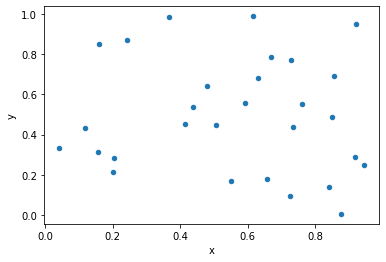

In [29]:
X2.data.plot.scatter("x", "y")

In [30]:
X2.data

,x,y,xopt_exception,xopt_traceback,xopt_runtime,f1,xopt_error,xopt_error_str
4,0.116977,0.430299,None,,0.300445,0.198841,False,NaN
1,0.242342,0.870193,None,,0.300608,0.815964,False,NaN
2,0.658418,0.177374,None,,0.301038,0.464976,False,NaN
3,0.478615,0.639232,None,,0.300815,0.637690,False,NaN
5,0.550858,0.169767,None,,0.300928,0.332265,False,NaN
6,0.760978,0.552324,None,,0.300695,0.884149,False,NaN
7,0.669859,0.786717,None,,0.300810,1.067635,False,NaN
8,0.733491,0.438846,None,,0.301105,0.730594,False,NaN
9,0.202318,0.283422,None,,0.301086,0.121261,False,NaN
10,0.944483,0.250679,x > 0.8,"Traceback (most recent call last):\n File ""/U...",0.301404,NaN,True,"Traceback (most recent call last):\n File ""/U..."
